# Deep Learning projet 2

#### DALBERTO Jonathan, JEANNOT Ferréol, KALARIS Florian, ROBERT Simon
Classification d'images: détecter la pneumonie sur des images de rayons X.

Jonathan : recherche sur le modèle à utiliser en source pour l'extraction de feature et le fine tuning, documentation.

Ferréol : Implémentation, Documentation

Florian : Implémentation, Documentation

Simon : Correction, Documentation, étude et exploration du DataSet

## En partant de zéro

La première étape fut de récupérer le dataset sur Kaggle. Fort heureusement, l'opération est plutôt simple dans un notebook Colab.

In [0]:
import os
from google.colab import drive

drive.mount('/content/gdrive')

os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Colab Notebooks/Kaggle"
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip

drive.flush_and_unmount()

# Le log de ce fragment de code a été retiré à cause de la longeur du dézippage

Le dataset Kaggle prévoit déjà un découpage entre des données d'entrainement, de validation et de test.

Grâce à *matplotlib*, nous pouvons afficher des images du dataset.
Nous constatons qu'à l'oeil nu, sans formation de médecine, nous n'arrivons pas du tout à trouver de différences concrètes entre des poumons sains et de poumons d'une personne atteinte par la pneumonie (des images différentes sont chargées à chaque éxécution).

Text(0.5, 1.0, 'Pneumonia')

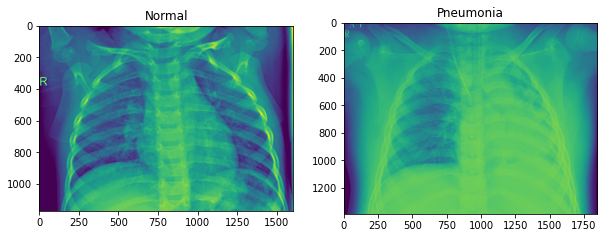

In [0]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

train_folder= 'chest_xray/chest_xray/train/'
val_folder = 'chest_xray/chest_xray/val/'
test_folder = 'chest_xray/chest_xray/test/'

train_n = train_folder + 'NORMAL/'
train_p = train_folder + 'PNEUMONIA/'

# Normal
rand_norm= np.random.randint(0,len(os.listdir(train_n)))
norm_pic = os.listdir(train_n)[rand_norm]

healty_address = train_n + norm_pic

# Pneumonie
rand_p = np.random.randint(0,len(os.listdir(train_p)))

sick_pic =  os.listdir(train_p)[rand_norm]
sick_address = train_p + sick_pic

norm_load = Image.open(healty_address)
sic_load = Image.open(sick_address)

# Plot images
f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load)
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(sic_load)
a2.set_title('Pneumonia')

### Création du modèle

Dans notre première approche, nous avons créé nous même un Réseau neurones.

En plus de l'utilisation de couches denses classiques, nous utilisons également deux couches de neurones convolutifs, qui permettent d'observer les images du DataSet par groupe de pixels superposés lors de l'observation.

Nous avons également ajouté deux couches de dropout après chaque convolutive afin de limiter les risques de surentraînement.


Ensuite, nous procédont à la création des jeux de données en découpant avec les dossiers déjà classés en '_train_', '_test_' et '_val_'.


Le sommaire nous indique que nous avons 707,905 paramètres entraînables sur notre réseau de neurones.

In [0]:
# Modèle CNN - Création

cnn = Sequential()

# Couche convolutive
cnn.add(Conv2D(32, (8, 8), activation="relu", input_shape=(64, 64, 3)))
cnn.add(Dropout(0.3))

# Couche de pooling, pour adapter l'output des couches convolutives
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Seconde couche convolutive
cnn.add(Conv2D(32, (3, 3), activation="relu"))
cnn.add(Dropout(0.3))

# Seconde couche de pooling
cnn.add(MaxPooling2D(pool_size = (2, 2)))


# Couche 'Flatten', pour rendre la donnée bidimentionelle, suivie de deux couches denses dites 'classiques', dont la dernière est notre couche de sortie du réseau
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'sigmoid', units = 1))

# Compilation du modèle
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])



train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255) 

training_set = train_datagen.flow_from_directory('chest_xray/chest_xray/train',
    target_size = (64, 64),
    batch_size = 32,
    class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory('chest_xray/chest_xray/val/',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary')

test_set = test_datagen.flow_from_directory('chest_xray/chest_xray/test',
    target_size = (64, 64),
    batch_size = 32,
    class_mode = 'binary')

cnn.summary()

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 57, 57, 32)        6176      
_________________________________________________________________
dropout_1 (Dropout)          (None, 57, 57, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
dropout_2 (Dropout)          (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0       

### Entrainement

Nous lançons un entraînement sur dix époques, en rajoutant une validation après chaque époque, qui même si le jeu de données de validation n'est pas très fourni, nous de bien visualiser la progression du modèle.


In [0]:
# Modèle CNN - Entrainement
cnn_model = cnn.fit_generator(training_set,
    epochs = 10,
    validation_data = validation_generator,
    validation_steps = 20
    )

Epoch 1/10
163/163 [==============================] - 189s 1s/step - loss: 0.1540 - accuracy: 0.9400 - val_loss: 0.3900 - val_accuracy: 0.8125
Epoch 2/10
163/163 [==============================] - 189s 1s/step - loss: 0.1558 - accuracy: 0.9342 - val_loss: 0.3298 - val_accuracy: 0.9375
Epoch 3/10
163/163 [==============================] - 189s 1s/step - loss: 0.1636 - accuracy: 0.9316 - val_loss: 0.3752 - val_accuracy: 0.8750
Epoch 4/10
163/163 [==============================] - 186s 1s/step - loss: 0.1398 - accuracy: 0.9433 - val_loss: 0.3730 - val_accuracy: 0.8125
Epoch 5/10
163/163 [==============================] - 190s 1s/step - loss: 0.1578 - accuracy: 0.9348 - val_loss: 0.3352 - val_accuracy: 0.9375
Epoch 6/10
163/163 [==============================] - 190s 1s/step - loss: 0.1315 - accuracy: 0.9500 - val_loss: 0.3802 - val_accuracy: 0.8125
Epoch 7/10
163/163 [==============================] - 186s 1s/step - loss: 0.1362 - accuracy: 0.9477 - val_loss: 0.3027 - val_accuracy: 0.9375

Le modèle, avec ses données d'entrainement, atteint une précision de 95% (selon ses propres relevés pendant les époques d'entrainement), contre une moyenne de 85% dans ses rapports de validation.



> #### Sauvegarde & Chargement
Il est important, après tant de temps investi à entrainer un modèle, de l'exporter afin de pouvoir le reprendre plus tard. C'est d'autant plus important du fait que Colab ne fait pas persister les environnements d'exécution bien longtemps. Grâce aux deux cellules de code suivantes, on peut sauvegarder et charger le modèle depuis son drive Google.

In [0]:
# Modèle CNN - Sauvegarde
drive.mount('/content/gdrive')
cnn.save('/content/gdrive/My Drive/Colab Notebooks/model_cnn.h5')
drive.flush_and_unmount()

Mounted at /content/gdrive


In [0]:
# Modèle CNN - Chargement
from tensorflow.keras.models import load_model
drive.mount('/content/gdrive')
cnn = load_model('/content/gdrive/My Drive/Colab Notebooks/model_cnn.h5')
drive.flush_and_unmount()

Mounted at /content/gdrive


### Test et comparaison avec des performances humaines

Lorsqu'on teste le modèle avec le jeu prévu à cet effet, on constate une précision d'environ **89.6%**.

Selon les chiffres du *National Center for Biotechnology Information*, le taux de mauvais diagnostics de la pneumonie aux États-Unis se situe autour de 38%. *(source: [https://www.ncbi.nlm.nih.gov/pubmed/8432152](https://www.ncbi.nlm.nih.gov/pubmed/8432152))*

Notre modèle est donc assez prometeur avec un taux de mauvais diagnostics de 10.4%


Une poursuite intéréssante dans les tests de notre modèle serait d'effectuer une classification sur des images de patients mal diagnostiqués par des médecins.


In [0]:
test_accu = cnn.evaluate_generator(test_set,steps=312)
print('The testing accuracy is :',test_accu[1]*100, '%')

The testing accuracy is : 89.60044980049133 %


Vous trouverez plus bas les mesures de Loss et de Précision mesurées pendant l'entrainement du modèle.

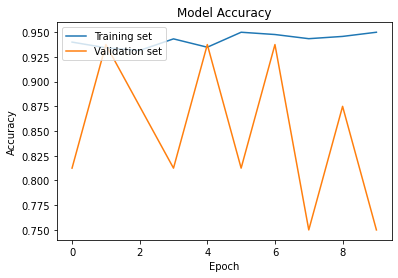

In [0]:
# Accuracy 
plt.plot(cnn_model.history['accuracy'])
plt.plot(cnn_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()


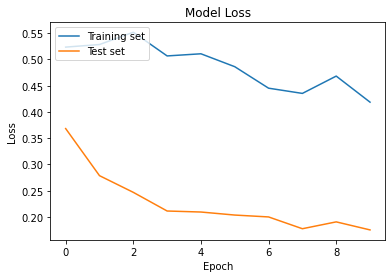

In [0]:
# Loss 

plt.plot(cnn_model.history['val_loss'])
plt.plot(cnn_model.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()

## En utilisant l'extraction de features (_DenseNet201_)

Dans l'optique de produire une IA plus performante, nous avons tenté une seconde approche en utilisant un modèle déjà existant: ***DenseNet201***, un réseau de neurones convolutifs étant déjà enregistré dans Keras. Notre choix c'est arrêté sur lui car il a déjà été utilisé dans le domaine médical, notamment pour le diagnostic du cancer du sein. (Source: [https://link.springer.com/article/10.1007/s00138-019-01042-8](https://link.springer.com/article/10.1007/s00138-019-01042-8)).


L'objectif ici est donc de réutiliser ***DenseNet201*** en rajoutant une couche de sortie adaptée à nos classes ('NORMAL' et 'PNEUMONIA').



> Le principal défi de la partie de code qui va suivre fut d'adapter le contenu des dossiers en Dataset de Tenseurs valides. Plusieurs heures de travail ont été nécéssaires pour touver la bonne méthode pour convertir le *DirectoryIterator* que nous avions utilisé avec notre propre IA en *Dataset* valide pouvant être compris par l'implémentation TensorFlow de ***DenseNet201***

> Le problème rencontré venait que la méthode que nous avons utilisé, *flow_from_directory()*, ne créait non pas un *Dataset* contenant des tenseurs mais un *Generator* produisant des tuples. Un combat était donc lancé entre le développeur et la machine.

> Cinq cafés plus tard et un historique internet rempli de StackOverflow, nous avions trouvé la solution. (le code qui suit a été allègrement volé sur internet)

In [0]:
import tensorflow as tf

BATCH_SIZE = 16
IMG_DIM = 224
NB_CLASSES = 2

img_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20
)

train_ds = tf.data.Dataset.from_generator(lambda: img_gen.flow_from_directory(
      'chest_xray/chest_xray/train',
      target_size = (IMG_DIM, IMG_DIM),
      batch_size=BATCH_SIZE,
      class_mode = 'binary'
    ),
  output_types=(tf.float32, tf.float32),
  output_shapes=([BATCH_SIZE, IMG_DIM, IMG_DIM, 3],
                [BATCH_SIZE])
  )

test_ds = tf.data.Dataset.from_generator(lambda: img_gen.flow_from_directory(
      'chest_xray/chest_xray/test',
      target_size = (IMG_DIM, IMG_DIM),
      batch_size=BATCH_SIZE,
      class_mode = 'binary'
    ),
  output_types=(tf.float32, tf.float32),
  output_shapes=([BATCH_SIZE, IMG_DIM, IMG_DIM, 3],
                [BATCH_SIZE])
  )

val_ds = tf.data.Dataset.from_generator(lambda: img_gen.flow_from_directory(
      'chest_xray/chest_xray/val',
      target_size = (IMG_DIM, IMG_DIM),
      batch_size=BATCH_SIZE,
      class_mode = 'binary'
    ),
  output_types=(tf.float32, tf.float32),
  output_shapes=([BATCH_SIZE, IMG_DIM, IMG_DIM, 3],
                [BATCH_SIZE])
  )

for image_batch, label_batch in train_ds.take(1): # parce que pour une quelconque raison `image_batch, label_batch = train_ds.take(1)` ne fonctionne pas... !@/$#%?!
   pass

print(image_batch.shape) # Vérification que la 'shape' de sortie est bien au format Tensor

Found 5216 images belonging to 2 classes.
(16, 224, 224, 3)


Après ce sang et ces larmes, nous devions alors importer le modèle pré entrainé.

Attention, le sommaire de ce réseau de neurones est très grand.

In [0]:
from tensorflow.keras.applications import DenseNet201 as pretrained_model
from tensorflow.keras.models import Model
IMG_SHAPE = (IMG_DIM, IMG_DIM, 3)

base_model = pretrained_model(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False # Blocage de l'entrainement des couches du modèle déjà entrainées

base_model.summary()


74842112/74836368 [==============================] - 1s 0us/step
Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________

Une fois le modèle chargé, il convient de rajouter une couche de Pooling, qui, comme indiqué plus haut, va nous permettre d'envoyer une prediction à la couche dense qui suit.


La couche dense qui suit a un output binaire, qui nous permet de prédire si un patient est sain ou si un patient est atteint de pneumonie.

In [0]:
feature_batch = base_model(image_batch)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)


Le rajout de ces deux nouvelles couche se fait sur un nouveau modèle séquentiel.

TensorFlow, ou plutôt Keras, reconnaît ***DenseNet201*** et ne nous réaffiche pas son sommaire dans sa totalité, mais seulement son nom (heureusement).



> Nous constatons également que seulement deux variables sont entraînables: celles de la couche dense que nous avons rajouté.


In [0]:
model = None
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])
model.compile(
  optimizer=tf.keras.optimizers.RMSprop(),
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  metrics=['accuracy']
)
model.summary()
print(f"Variables entraînables: {len(model.trainable_variables)}")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1921      
Total params: 18,323,905
Trainable params: 1,921
Non-trainable params: 18,321,984
_________________________________________________________________
Variables entraînables: 2


Comme nous pouvons le voir ci dessus, il n'y a que deux variable entrainables: celle du neurone unique que nous venons de rajouter sur la couche de sortie.

Un premier test sur le modèle se révèle assez inquiétant.

In [0]:
loss_densenet_raw, accuracy_densenet_raw = model.evaluate(test_ds, steps = 312)
print(f"loss: {loss_densenet_raw}")
print(f"précision: {accuracy_densenet_raw}")

Found 624 images belonging to 2 classes.
312/312 [==============================] - 146s 467ms/step - loss: 0.8540 - accuracy: 0.5511
loss: 0.8540388941764832
précision: 0.5510817170143127


En effet, celui-ci a a une précision de **55%**, mais ce n'est pas non plus décourageant, on sait qu'il comprend les formes qu'il voit sur l'image.
Pour l'améliorer, nous alons déjà entraîner la dernière couche que nous venons de rajouter.

Nous lançons donc l'entraînement, dans l'espoir d'améliorer les résultats.

In [0]:
initial_epochs = 10

history = model.fit(train_ds,
  epochs=initial_epochs,
  validation_data=val_ds,
  steps_per_epoch=326,
  validation_steps=32
)

Epoch 1/10
Found 5216 images belonging to 2 classes.
326/326 [==============================] - 123s 377ms/step - loss: 0.2223 - accuracy: 0.9143 - val_loss: 0.7029 - val_accuracy: 0.7070
Epoch 2/10
326/326 [==============================] - 120s 369ms/step - loss: 0.1347 - accuracy: 0.9457 - val_loss: 0.4768 - val_accuracy: 0.8184
Epoch 3/10
326/326 [==============================] - 121s 371ms/step - loss: 0.1159 - accuracy: 0.9532 - val_loss: 0.4232 - val_accuracy: 0.8379
Epoch 4/10
326/326 [==============================] - 121s 371ms/step - loss: 0.1060 - accuracy: 0.9563 - val_loss: 0.5056 - val_accuracy: 0.8047
Epoch 5/10
326/326 [==============================] - 121s 372ms/step - loss: 0.0969 - accuracy: 0.9628 - val_loss: 0.2792 - val_accuracy: 0.8984
Epoch 6/10
326/326 [==============================] - 121s 371ms/step - loss: 0.0931 - accuracy: 0.9628 - val_loss: 0.2985 - val_accuracy: 0.8926
Epoch 7/10
326/326 [==============================] - 121s 371ms/step - loss: 0.08

On a pu tout au long de l'entraînement constater qu'il y avait une amélioration d'époque en époque, ce qui a pu nous confirmer assez vite que nous n'avions pas fait d'erreur pendant la configuration du modèle (beaucoup de passes ratées on eu lieux avant ça).

Une seule de ces étapes d'entrainement avec validation dure environ deux heures.

Voyons maintenant si cet entrainement, bien qu'impactant très peu de paramètres, a porté ses fruits.

In [0]:
loss_densenet_output_trained, accuracy_densenet_output_trained = model.evaluate(test_ds, steps = 312)
print(f"loss: {loss_densenet_output_trained}")
print(f"précision: {accuracy_densenet_output_trained}")

Found 624 images belonging to 2 classes.
312/312 [==============================] - 100s 320ms/step - loss: 0.5414 - accuracy: 0.8301
loss: 0.5413810610771179
précision: 0.8301281929016113


Le résultat est plutôt prometteur, en entrainant le modèle sur uniquement la dernière couche (dense, neurone unique), la précision est montée à **83%**, seulement 6% en dessous de notre propre réseau de neurones convolutif!

Sur les graphiques qui vont suivre, nous pouvont suivre la progression du modèle en voyant l'augmentation de sa précision et la diminution de la perte.

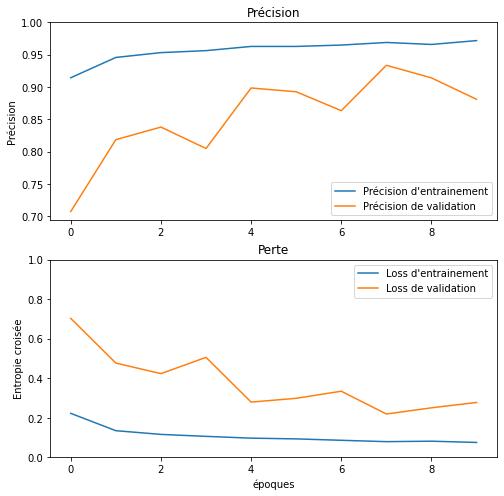

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8)) # Création d'un graphique permettant de visualiser les performances de du modèle
plt.subplot(2, 1, 1)
plt.plot(acc, label='Précision d\'entrainement')
plt.plot(val_acc, label='Précision de validation')
plt.legend(loc='lower right')
plt.ylabel('Précision')
plt.ylim([min(plt.ylim()),1])
plt.title('Précision')

plt.subplot(2, 1, 2) # Création d'un graphique représentant la perte
plt.plot(loss, label='Loss d\'entrainement')
plt.plot(val_loss, label='Loss de validation')
plt.legend(loc='upper right')
plt.ylabel('Entropie croisée')
plt.ylim([0,1.0])
plt.title('Perte')
plt.xlabel('époques')
plt.show()

## Fine tuning

Bien sûr, il serait dommage de s'arrêter là. Afin d'améliorer les performances de ce modèle, en espérant dépasser le réseaux convolutif que nous avons créé plus tôt, nous allons tenter de réentrainer les dernières couches de ___DenseNet201___, afin de les adapter à notre Dataset bien particulier.

In [0]:
base_model.trainable = True # dévérouillage de toutes les couches du modèle densenet201
print(f"Couches du modèle de base: {len(base_model.layers)}") # 707
print()

fine_tune_at = 550 # Couche à partir de laquelle on va réentrainer le modèle

# Verouillage de toutes les couches avant celle de la variable `fine_tune_at`
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # Comme le modèle référence directement le base_model, il suffit de le recompiler pour que celui çi
              optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),        # prenne en compte les modifications effectuées (dévérouillage des couches).
              metrics=['accuracy'])

model.summary()

print(f"Variables entraînables: {len(base_model.trainable_variables)}")


Couches du modèle de base: 707

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1921      
Total params: 18,323,905
Trainable params: 6,547,905
Non-trainable params: 11,776,000
_________________________________________________________________
Variables entraînables: 177


De seulement deux variables entraînables qui étaient nos couches de sortie, nous passons à 177, et nous pourions facilement en avoir encore plus en devérouillant plus de couches du modèle d'origine.

Notez dans la cellule de code suivante que l'entrainement va reprendre à l'étape 10. En effet, après avoir modifié puis recompilé le modèle, nous pouvons quand même reprendre l'entrainement là ou on l'a laissé quand on entrainaît que la dernière couche. Cela nous permet d'avoir un léger gain de précision.

In [0]:
fine_tune_epochs = 15

total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
  epochs=total_epochs,
  initial_epoch =  history.epoch[-1],
  steps_per_epoch=326,
  validation_steps=16,
  validation_data=val_ds
)


Epoch 10/25
Found 5216 images belonging to 2 classes.
326/326 [==============================] - 121s 370ms/step - loss: 0.0075 - accuracy: 0.9964 - val_loss: 0.1949 - val_accuracy: 0.9492
Epoch 11/25
326/326 [==============================] - 120s 369ms/step - loss: 0.0041 - accuracy: 0.9985 - val_loss: 0.0340 - val_accuracy: 0.9961
Epoch 12/25
326/326 [==============================] - 120s 368ms/step - loss: 0.0071 - accuracy: 0.9975 - val_loss: 0.0720 - val_accuracy: 0.9805
Epoch 13/25
326/326 [==============================] - 119s 365ms/step - loss: 0.0039 - accuracy: 0.9988 - val_loss: 0.2943 - val_accuracy: 0.9219
Epoch 14/25
326/326 [==============================] - 120s 369ms/step - loss: 0.0063 - accuracy: 0.9979 - val_loss: 0.0239 - val_accuracy: 0.9883
Epoch 15/25
326/326 [==============================] - 121s 370ms/step - loss: 0.0042 - accuracy: 0.9985 - val_loss: 0.0773 - val_accuracy: 0.9727
Epoch 16/25
326/326 [==============================] - 120s 368ms/step - los

Nous constatons tout d'abord des scores de validation plutôt ahurissants.

Il est important de préciser qu'au point où nous en sommes, les entraînements durent un certain temps, la précision augmente très lentement au même titre que la loss diminue. Et pendant ce temps, le risque de surentraîner le modèle est omniprésent.

Le but final est de gagner quelques fractions de pourcentage de précision petit à petit tout en évitant de surentraîner le modèle.

Nous allons mainenant voir si le modèle est très efficace, ou effectivement surentraîné.

In [26]:
loss_densenet_fine_tuned, accuracy_densenet_fine_tuned = model.evaluate(test_ds, steps = 312)
print(f"loss: {loss_densenet_fine_tuned}")
print(f"précision: {accuracy_densenet_fine_tuned}")

312/312 [==============================] - 100s 320ms/step - loss: 1.8228 - accuracy: 0.8251
loss: 1.8228464126586914
précision: 0.825120210647583
Found 624 images belonging to 2 classes.
312/312 [==============================] - 100s 320ms/step - loss: 1.8168 - accuracy: 0.8259
loss: 1.8167777061462402
précision: 0.8259214758872986


Comme on peut s'y attendre, le modèle ne présente pas la précision atteinte lors des étapes de validation. Ce qui est plus surprenant, c'est qu'il n'atteint même pas le score de notre autre réseau de neurones puisque qu'il affiche une précision de **82.5%**. Le résultat reste quand même très correct, les pneumologues n'ont qu'a bien se tenir!

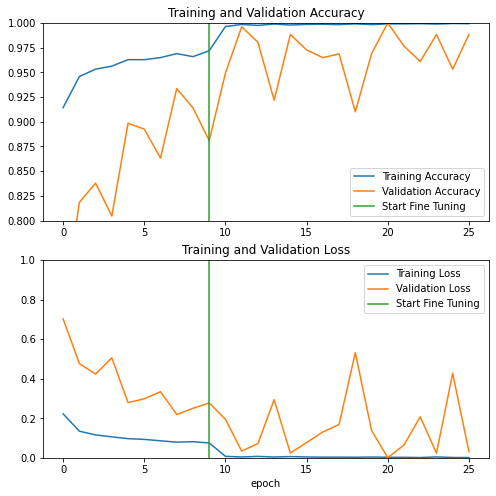

In [24]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


## Rétrospective

Bien qu'il convienne que la précision de ces modèles soit remarquable, il est tout de même important de souligner que certains points auraient pu être abordés différement pour atteindre un meilleur score.

- L'exploration des données a révélé que seulement 16 images étaient utilisées pour le jeu de validation, en avoir plus aurait pu garantir un entraînement plus efficace.
- D'une manière générale, un Dataset plus grand aurait pu permettre moins de surentraînement.
- Une recherche plus approfondie des paramètre de fine-tuning (nombre d'époques, nombre de couches à partir de laquelle on réentraîne, optimiseur, etc...)
- Un problème non identifié provoquait un nombre d'étapes infinies sur les époques, nous obligeant à mettre un nombre défini, ce qui a du sérieusement impacter l'entraînement.